# Exploratory Data Analysis - MIMIC-III v1.4

In this notebook we will be performing an exploratory data analysis (EDA) of the **'Medical Information Mart for Intensive Care III'** database, or **MIMIC-III** (v1.4) <span>&#8213;</span> a free, publicly-available database comprising information relating to patients admitted to intensive care units in the United States from 2008 to 2014.

We will be exploring the available tables after processing the PostgreSQL database with `MIMIC Code` <span>&#8213;</span> an open-source repository used to extract various medical concepts (e.g. *sofa/qsofa/sirs scores*, *sepsis definitions*, etc.) from MIMIC-III in a reproducible manner (source code can be found [here](https://github.com/MIT-LCP/mimic-code)).

We will analyze the following output tables relevant to the project:
- `cohort.csv`
- `demographics_cohort.csv`
- `fio2_cohort.csv`
- `inputevents_cv/mv_cohort.csv`
- `labs_cohort.csv`
- `urineoutput_cohort.csv`
- `vasopressors_cv/mv_cohort.csv`
- `vitals_cohort.csv`

In [1]:
# dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from collections import defaultdict

# Directory in which final dataset is stored
RAW_DATA_DIR = '../data/mimic-iii-clinical-database-demo-1.4'
DATA_DIR = '../data/mimic-iii/final'

### Convenience functions

In [2]:
# Read CSV from file and parse dates using pd.to_datetime()
def read_csv(fname):
    df = pd.read_csv(fname)
    
    parse_dates = ['intime', 'outtime', 'window_start', 'window_end', 'charttime', 'suspected_infection_time_poe']
    for col in parse_dates:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col])
    return df

# Plots a histogram for each column in `col_names`
def histogram_cols(df, col_names=[], bins=50, num_cols=2, xlabel='Value', ylabel='Frequency'):
    num_rows = int(np.ceil(len(col_names) / num_cols))
    
    plt.figure(figsize=(num_cols * 6.4, num_rows * 4.8)) # pyplot default
    for i, col_name in enumerate(col_names):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.hist(df[col_name].values, bins=bins)
        plt.title(col_name)
        plt.xlabel(xlabel if isinstance(xlabel, str) else xlabel[i])
        plt.ylabel(ylabel if isinstance(ylabel, str) else ylabel[i])
    plt.show()
    
# Plots a histogram of values under `value_col`, grouped by `group_col`
def histogram_col_indexed(df, value_col, group_col, bins=50, num_cols=2, xlabel='Value', ylabel='Frequency'):
    num_plots = len(set(df[group_col].values))
    num_rows = int(np.ceil(num_plots / num_cols))
    
    plt.figure(figsize=(num_cols * 6.4, num_rows * 4.8)) # pyplot default
    for i, (group_label, group_df) in enumerate(df.groupby(group_col)):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.hist(group_df[value_col].values, bins=bins)
        plt.title(group_label)
        plt.xlabel(xlabel if isinstance(xlabel, str) else xlabel[i])
        plt.ylabel(ylabel if isinstance(ylabel, str) else ylabel[i])
    plt.show()
    
# Bins data into time-blocks defined by freq (default: '1 hour') and 
# computes percentage of blocks in which items in `item_col` are recorded.
def missing_values_in_intervals(df, item_col=None, freq='1H'):
    df['rounded_charttime'] = df['charttime'].dt.round(freq='H')
    df['rounded_window_start'] = df['window_start'].dt.round(freq='H')
    df['rounded_window_end'] = df['window_end'].dt.round(freq='H')
    
    measurements = defaultdict(list)

    # Consider ICU stays separately
    for icustay_id, icustay_data in df.groupby('icustay_id'):
        # Define hourly intervals from `starttime` to `endtime`
        starttime = icustay_data['rounded_window_start'].min()
        endtime = icustay_data['rounded_window_end'].max()
        date_range = set(pd.date_range(start=starttime, end=endtime, freq='1H'))

        # Check recordings of each item (e.g. vital)
        for item_id, item_data in icustay_data.groupby(item_col):
            timestamps = set(item_data['rounded_charttime'])

            # Percentage of `date_range` covered
            perc_measured = len(timestamps.intersection(date_range)) / len(date_range)
            measurements[item_id].append(perc_measured)
        
    return {item:np.mean(measurements[item]) for item in measurements.keys()}

---
## Patient Cohort and Admissions (`cohort.csv`/`ADMISSIONS.csv`)

In [3]:
# Load cohort.csv data
cohort_df = read_csv(DATA_DIR + '/cohort.csv')
cohort_df.head()

,subject_id,hadm_id,icustay_id,intime,outtime,suspected_infection_time_poe,window_start,window_end,hospital_expire_flag
0,10006,142345,206504,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 15:30:00,2164-10-22 15:30:00,2164-10-25 15:30:00,0
1,10013,165520,264446,2125-10-04 23:38:00,2125-10-07 15:13:52,2125-10-05 02:00:00,2125-10-04 02:00:00,2125-10-07 02:00:00,1
2,10017,199207,204881,2149-05-29 18:52:29,2149-05-31 22:19:17,2149-05-27 05:15:00,2149-05-26 05:15:00,2149-05-29 05:15:00,0
3,10019,177759,228977,2163-05-14 20:43:56,2163-05-16 03:47:04,2163-05-14 21:52:00,2163-05-13 21:52:00,2163-05-16 21:52:00,1
4,10026,103770,277021,2195-05-17 07:40:18,2195-05-19 17:24:25,2195-05-17 09:12:00,2195-05-16 09:12:00,2195-05-19 09:12:00,0


In [4]:
# Extract patient, hospital admission and ICU admission IDs
subject_ids = set(cohort_df['subject_id'])
hadm_ids = set(cohort_df['hadm_id'])
icustay_ids = set(cohort_df['icustay_id'])

# Average hospital stay time in days
avg_duration = round((cohort_df['outtime'] - cohort_df['intime']).mean().total_seconds() / (3600 * 24), 1)
std_duration = round((cohort_df['outtime'] - cohort_df['intime']).std().total_seconds() / (3600 * 24), 1)

# Average time to infection in days
avg_time_to_infect = round((cohort_df['suspected_infection_time_poe'] - cohort_df['intime']).mean().total_seconds() / (3600 * 24), 1)
std_time_to_infect = round((cohort_df['suspected_infection_time_poe'] - cohort_df['intime']).std().total_seconds() / (3600 * 24), 1)

# Results
print('\033[1m'+'Full cohort:'+'\x1b[0m')
print('Total patients:          ', len(subject_ids))
print('Total hosp. admissions:  ', len(hadm_ids))
print('Total ICU admissions:    ', len(icustay_ids))
print('Avg. ICU adm. / patient: ', len(icustay_ids) / len(subject_ids))
print('Avg. time at ICU:         %s days (±%s days)' % (avg_duration, std_duration))
print('Avg. time to infection:   %s days (±%s days)\n' % (avg_time_to_infect, std_time_to_infect))

Full cohort:
Total patients:           60
Total hosp. admissions:   60
Total ICU admissions:     60
Avg. ICU adm. / patient:  1.0
Avg. time at ICU:         5.6 days (±7.9 days)
Avg. time to infection:   -0.2 days (±2.5 days)



#### In-hospital mortality

In [5]:
# Determine list of ICU-stays involving males and females (from demographics.csv table)
demographic_df = read_csv(DATA_DIR + '/demographics_cohort.csv')
is_male = [r['icustay_id'] for _, r in demographic_df.iterrows() if r['is_male']]
is_female = [r['icustay_id'] for _, r in demographic_df.iterrows() if not r['is_male']]


# Compute %-mortality in groups
in_hosp_mortality = round(cohort_df['hospital_expire_flag'].mean() * 100, 1)
in_hosp_mortality_male = round(cohort_df[cohort_df['icustay_id'].isin(is_male)]['hospital_expire_flag'].mean() * 100, 1)
in_hosp_mortality_female = round(cohort_df[cohort_df['icustay_id'].isin(is_female)]['hospital_expire_flag'].mean() * 100, 1)

print('\033[1m'+'Mortality:'+'\x1b[0m')
print('In-hosp. mortality (overall): %s%%' % in_hosp_mortality)
print('In-hosp. mortality (male):    %s%%' % in_hosp_mortality_male)
print('In-hosp. mortality (female):  %s%%' % in_hosp_mortality_female)

Mortality:
In-hosp. mortality (overall): 31.7%
In-hosp. mortality (male):    32.1%
In-hosp. mortality (female):  31.2%


#### Types of admissions (in original database)

In [6]:
# Admissions from original MIMIC database
admissions_df = read_csv(RAW_DATA_DIR + '/ADMISSIONS.csv')

# Admission types and their frequency
admissions_df['diagnosis'].value_counts()

SEPSIS                                  10
PNEUMONIA                                8
SHORTNESS OF BREATH                      4
FEVER                                    4
CONGESTIVE HEART FAILURE                 3
                                        ..
SEPSIS;TELEMETRY                         1
HYPOTENSION;TELEMETRY                    1
CRITICAL AORTIC STENOSIS/HYPOTENSION     1
OVERDOSE                                 1
CHOLANGITIS                              1
Name: diagnosis, Length: 95, dtype: int64

#### Distribution of ICU stay durations

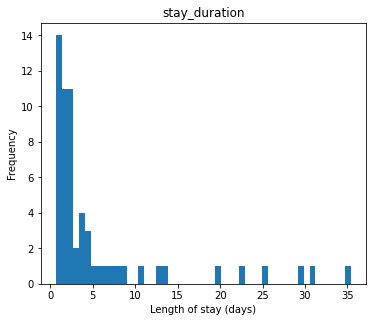

In [7]:
# Add column with stay durations
cohort_df['stay_duration'] = (cohort_df['outtime'] - cohort_df['intime']).dt.total_seconds() / (3600 * 24)

histogram_cols(cohort_df, col_names=['stay_duration'], xlabel='Length of stay (days)')

*Remarks:*
1. Sepsis most frequent diagnosis.
2. The negative `Avg. time to infection` indicates that patients often develop an infection prior to ICU admission (e.g. at a general ward).
3. Estimated mortality within hospital is approx. 30\% (to be expected from literature study).
    - Seemingly non-significant difference in mortality between men and women.
4. Primarily short stays less than 10 days, with a mean stay length of 5.6 days and a maximum of 35 days.

--- 
## Patient Demographics (`demographics_cohort.csv`)

In [8]:
demographics_df = read_csv(DATA_DIR + '/demographics_cohort.csv')
demographics_df.head()

,subject_id,hadm_id,icustay_id,age,is_male,race_white,race_black,race_hispanic,race_other,height,...,vent,sofa,lods,sirs,qsofa,qsofa_sysbp_score,qsofa_gcs_score,qsofa_resprate_score,elixhauser_hospital,blood_culture_positive
0,10076,198503,201006,68.8612,1,0,0,0,1,NaN,...,1,8,7,4,2,1,0,1,15,1
1,42321,114648,201204,80.5603,0,0,0,0,1,163.00,...,0,5,7,2,3,1,1,1,9,0
2,10045,126949,203766,68.6668,0,1,0,0,0,165.10,...,1,12,12,3,2,1,0,1,12,0
3,10104,177678,204201,70.5176,0,0,0,0,1,157.48,...,0,5,7,1,2,1,1,0,13,1
4,10017,199207,204881,73.6772,0,1,0,0,0,NaN,...,0,2,0,4,2,1,0,1,-1,0


#### Patient Characteristics: Gender & Ethnicity

In [9]:
print('\033[1m'+'Gender:'+'\x1b[0m')
print('Male:                 %s%%' % round(demographics_df['is_male'].mean() * 100, 1))
print('Female:               %s%%\n' % (100 - round(demographics_df['is_male'].mean() * 100, 1)))

print('\033[1m'+'Ethnicity:'+'\x1b[0m')
print('White:                %s%%' % round(demographics_df['race_white'].mean() * 100, 1))
print('Black:                %s%%' % round(demographics_df['race_black'].mean() * 100, 1))
print('Hispanic:             %s%%' % round(demographics_df['race_hispanic'].mean() * 100, 1))
print('Other:                %s%%\n' % round(demographics_df['race_other'].mean() * 100, 1))

print('\033[1m'+'Other:'+'\x1b[0m')
print('On Ventilator:        %s%%' % round(demographics_df['vent'].mean() * 100, 1))
print('Blood culture:        %s%%' % round(demographics_df['blood_culture_positive'].mean() * 100, 1))

Gender:
Male:                 46.7%
Female:               53.3%

Ethnicity:
White:                76.7%
Black:                6.7%
Hispanic:             3.3%
Other:                13.3%

Other:
On Ventilator:        45.0%
Blood culture:        48.3%


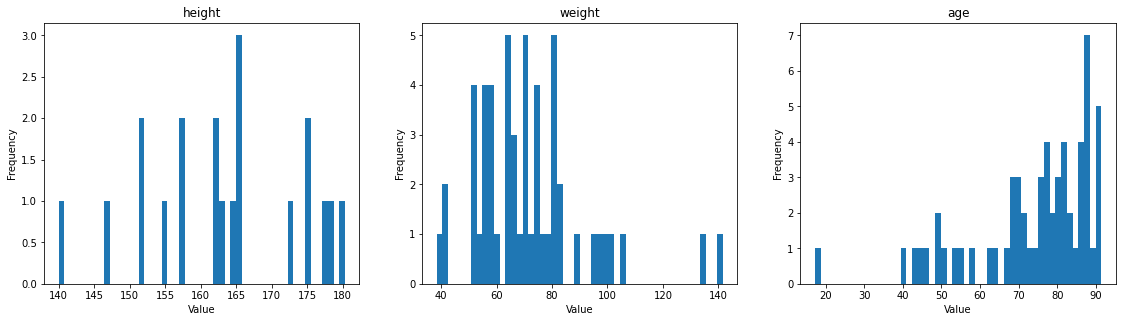

In [10]:
histogram_cols(demographics_df, col_names=['height', 'weight', 'age'], num_cols=3)

#### Disease Severity Scores

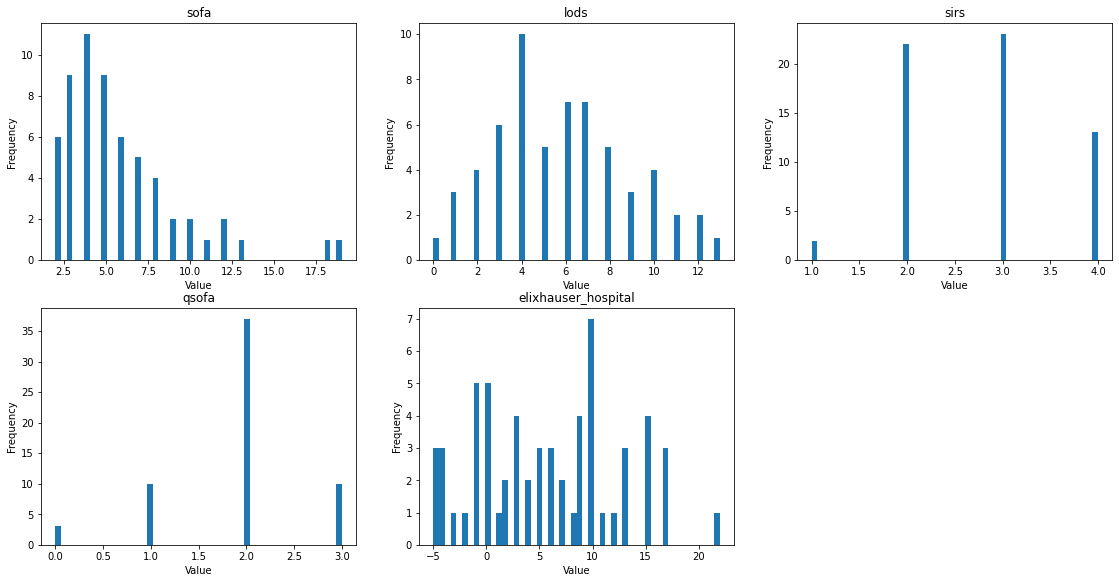

In [11]:
histogram_cols(demographics_df, col_names=['sofa', 'lods', 'sirs', 'qsofa', 'elixhauser_hospital'], num_cols=3)

*Remarks:*

1. Significant overrepresentation of `race_white` (76.6\%), yet a representative balance between men and women.
2. For a mere 48.3% of patients a blood culture is found (or grown?) which contradicts the idea that a culture must be found before sepsis can be verified. 
3. Overrepresentation of the elderly (expected as the elderly are more likely to develop sepsis).

---
## Vitals (`vitals_cohort.csv`)

In [12]:
# Load vitals.csv data
vitals_df = read_csv(DATA_DIR + '/vitals_cohort.csv')
vitals_df.head()

,subject_id,hadm_id,icustay_id,window_start,window_end,intime,outtime,charttime,vital_id,valuenum
0,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 22:40:00,DiasBP,50.000000
1,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 22:40:00,HeartRate,104.000000
2,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 22:40:00,MeanBP,63.666698
3,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 22:40:00,RespRate,25.000000
4,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 22:40:00,SpO2,98.000000


#### Mean number of measurements per ICU stay (per type)

In [13]:
vitals_df.groupby(['vital_id', 'icustay_id']).size().reset_index().groupby('vital_id')[0].mean()

vital_id
DiasBP       47.327273
Glucose       8.833333
HeartRate    46.290909
MeanBP       47.854545
RespRate     46.200000
SpO2         45.345455
SysBP        47.472727
TempC        13.833333
Name: 0, dtype: float64

#### Spread of measurements (by type):

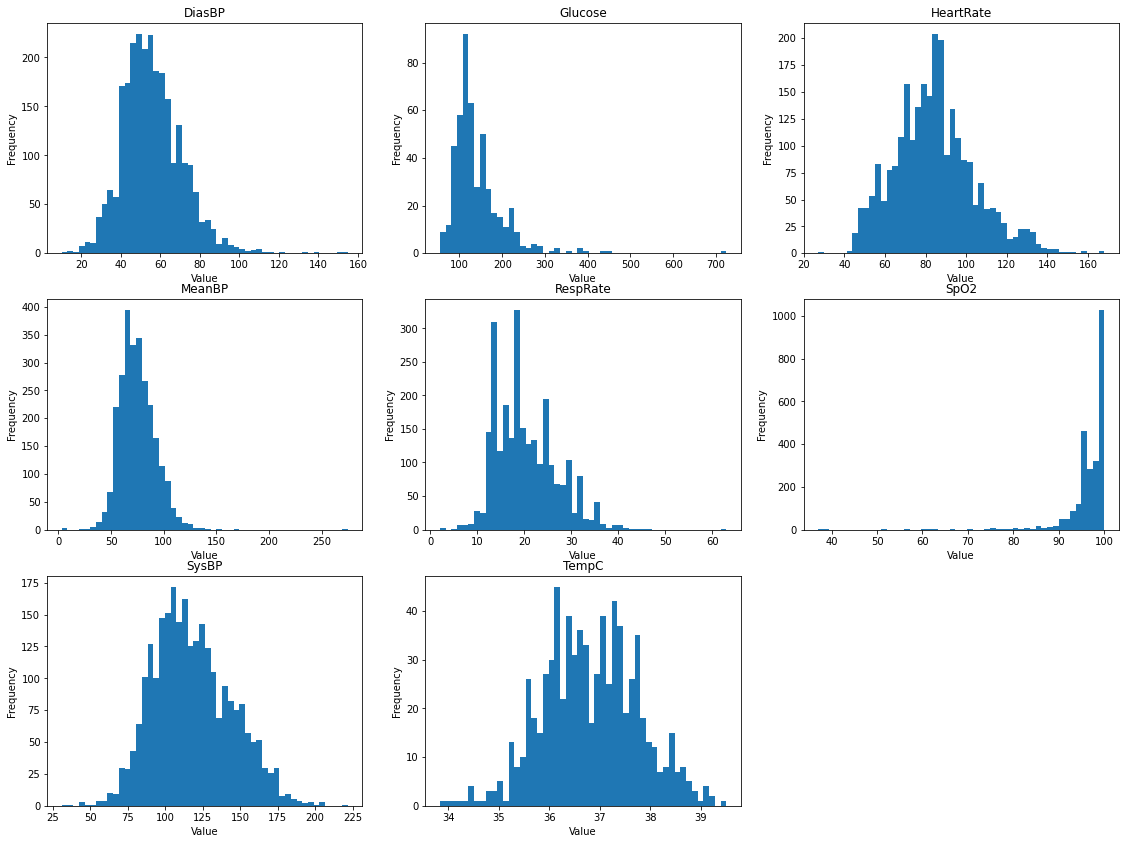

In [14]:
histogram_col_indexed(vitals_df, value_col='valuenum', group_col='vital_id', num_cols=3)

#### Distribution of $\Delta t$  (by type):

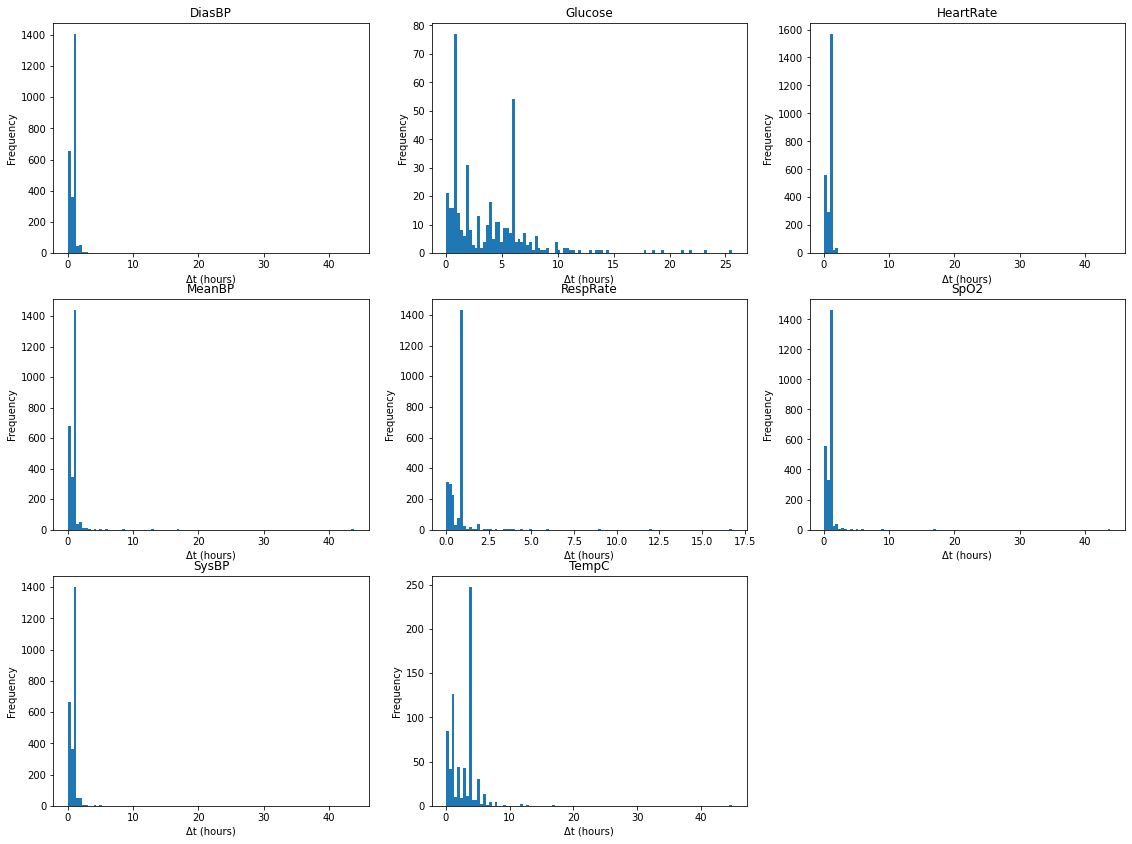

In [15]:
# Compute difference in measurement times for each measurement type in hours
vitals_df = vitals_df.sort_values(['icustay_id', 'charttime'])
vitals_df['time_diff'] = vitals_df.groupby(['icustay_id', 'vital_id'])['charttime'].diff().dt.total_seconds() / 3600

histogram_col_indexed(vitals_df, value_col='time_diff', group_col='vital_id', xlabel='Δt (hours)', bins=100, num_cols=3)

#### Missing values (in hourly windows)

In [16]:
out = missing_values_in_intervals(vitals_df, item_col='vital_id')
out['DiasBP'] = [out['DiasBP']] # To make pandas stop complaining

pd.DataFrame(out).round(3).rename({0: 'Recorded (%)'}) * 100

,DiasBP,Glucose,HeartRate,MeanBP,RespRate,SpO2,SysBP,TempC
Recorded (%),47.3,11.2,49.0,47.6,47.0,47.5,47.3,16.8


*Remarks:*

1. Different distributions for different vital functions (as expected as, e.g., `SpO2` maxes out at 100% which is where most patients will be).<br><br>

2. Considerable variability in $\Delta t$; most vital signals have a $\Delta t$ within 1~2 hours, with the exception of `Glucose` and `TempC`, which are being measured highly infrequently (on average, 8.8 and 13.8 times per patient, respectively).<br><br>

1. Missing value percentage is very high (>50\% for all vital signals considered).
    2. Temperature (`TempC`) and `Glucose` measurements are the most rare (as found previously), only being recorded in 16.7\% and 11.1\% of hours in the 72 hour time-frame considered.

---
## FiO2 (Fraction of Inspired Oxygen) (`fio2_cohort.csv`)

In [17]:
fio2_df = read_csv(DATA_DIR + '/fio2_cohort.csv')
fio2_df.head()

,subject_id,hadm_id,icustay_id,charttime,fio2
0,10013,165520,264446,2125-10-05 00:00:00,60.000002
1,10013,165520,264446,2125-10-05 01:00:00,40.000001
2,10013,165520,264446,2125-10-05 03:00:00,40.000001
3,10013,165520,264446,2125-10-05 07:00:00,69.999999
4,10013,165520,264446,2125-10-05 10:00:00,69.999999


#### Distribution of values:

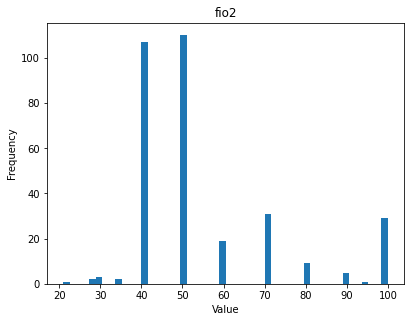

In [18]:
histogram_cols(fio2_df, col_names=['fio2'], num_cols=1)

#### Distribution of $\Delta t$:

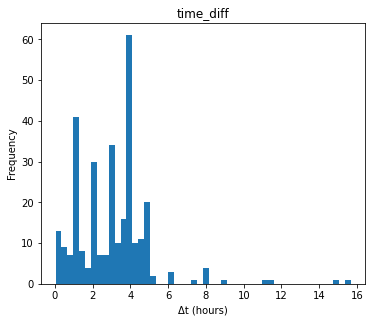

In [19]:
# Compute difference in measurement times for eaach measurement type in hours
fio2_df = fio2_df.sort_values(['icustay_id', 'charttime'])
fio2_df['time_diff'] = fio2_df.groupby(['icustay_id'])['charttime'].diff().dt.total_seconds() / 3600

histogram_cols(fio2_df, col_names=['time_diff'], xlabel='Δt (hours)', bins=50)

*Remarks:*
1. FiO2 measurements dicretized in steps of approx. 10\%
2. Significant spread in $\Delta t$ from 0 hours to $\pm$5 hours, with a maximum of 15.5 hours.

---
## Lab Results (`labs_cohort.csv`)

In [20]:
lab_df = read_csv(DATA_DIR + '/labs_cohort.csv')
lab_df.head()

,subject_id,hadm_id,icustay_id,window_start,window_end,intime,outtime,charttime,lab_id,valuenum
0,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 17:33:00,LACTATE,4.4
1,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 17:38:00,ALAT,9.0
2,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 17:38:00,ALBUMIN,3.4
3,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 17:38:00,ANION GAP,20.0
4,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 17:38:00,ASAT,40.0


#### Spread of measurements (by type):

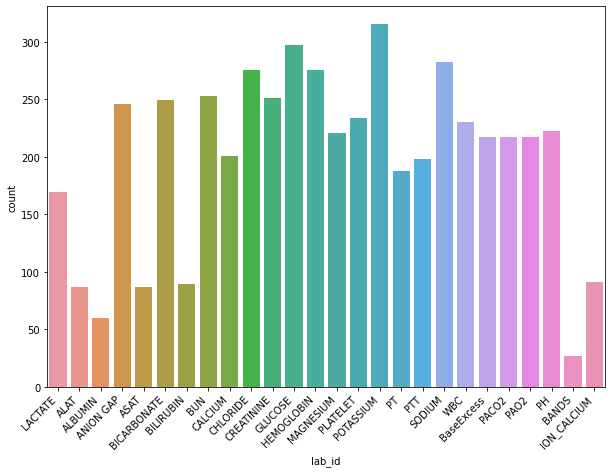

In [21]:
plt.figure(figsize=(10, 7))
seaborn.countplot(x=lab_df["lab_id"])
plt.xticks(rotation=45, ha='right');

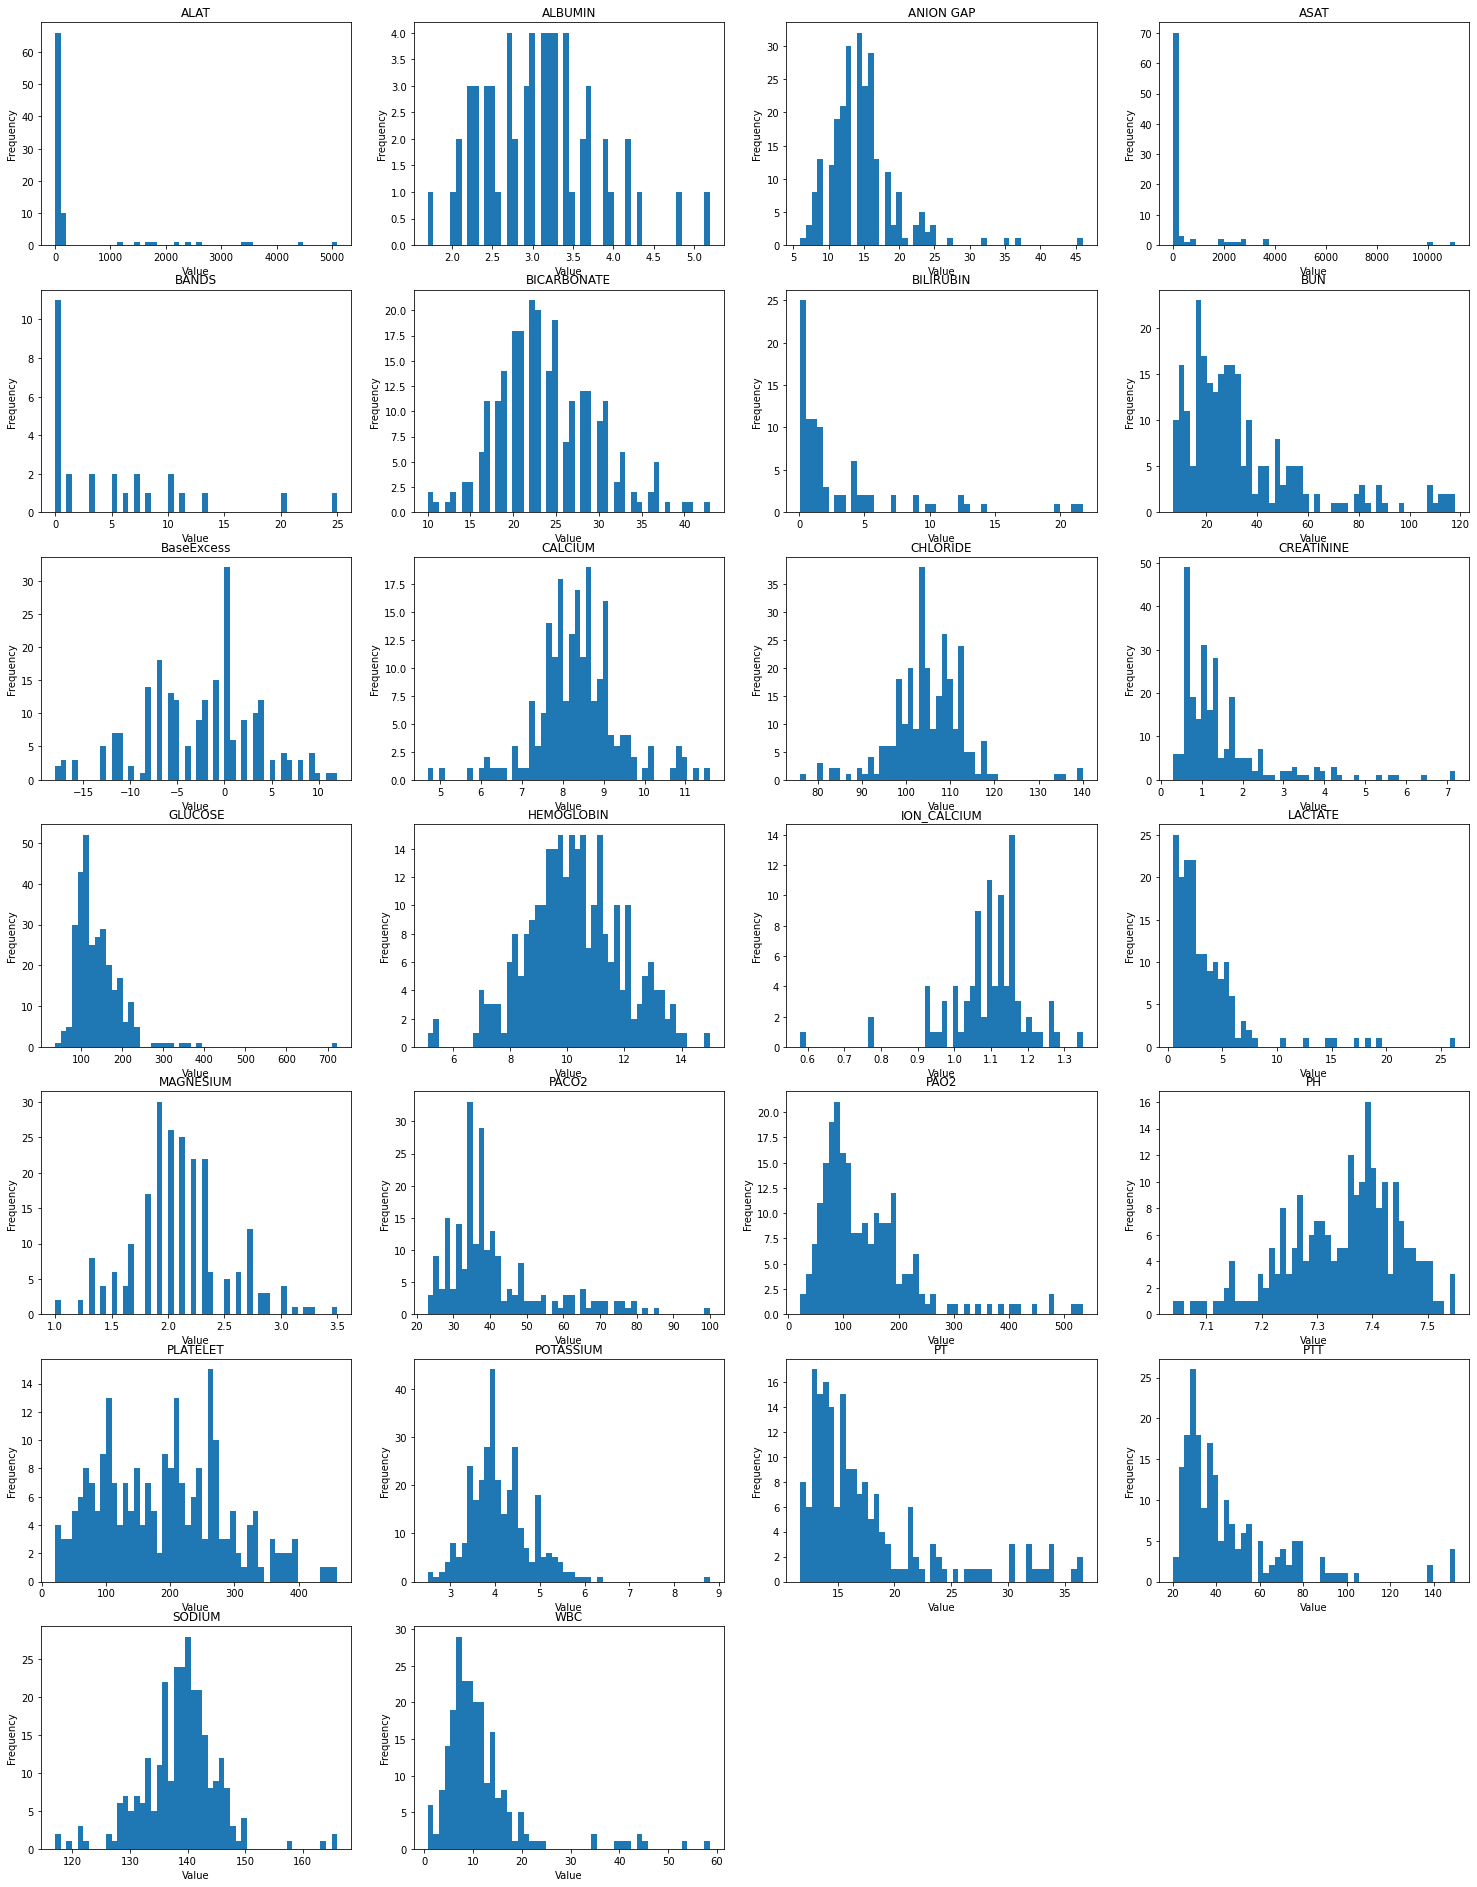

In [22]:
histogram_col_indexed(lab_df, value_col='valuenum', group_col='lab_id', num_cols=4)

#### Distribution of $\Delta t$ (by type):

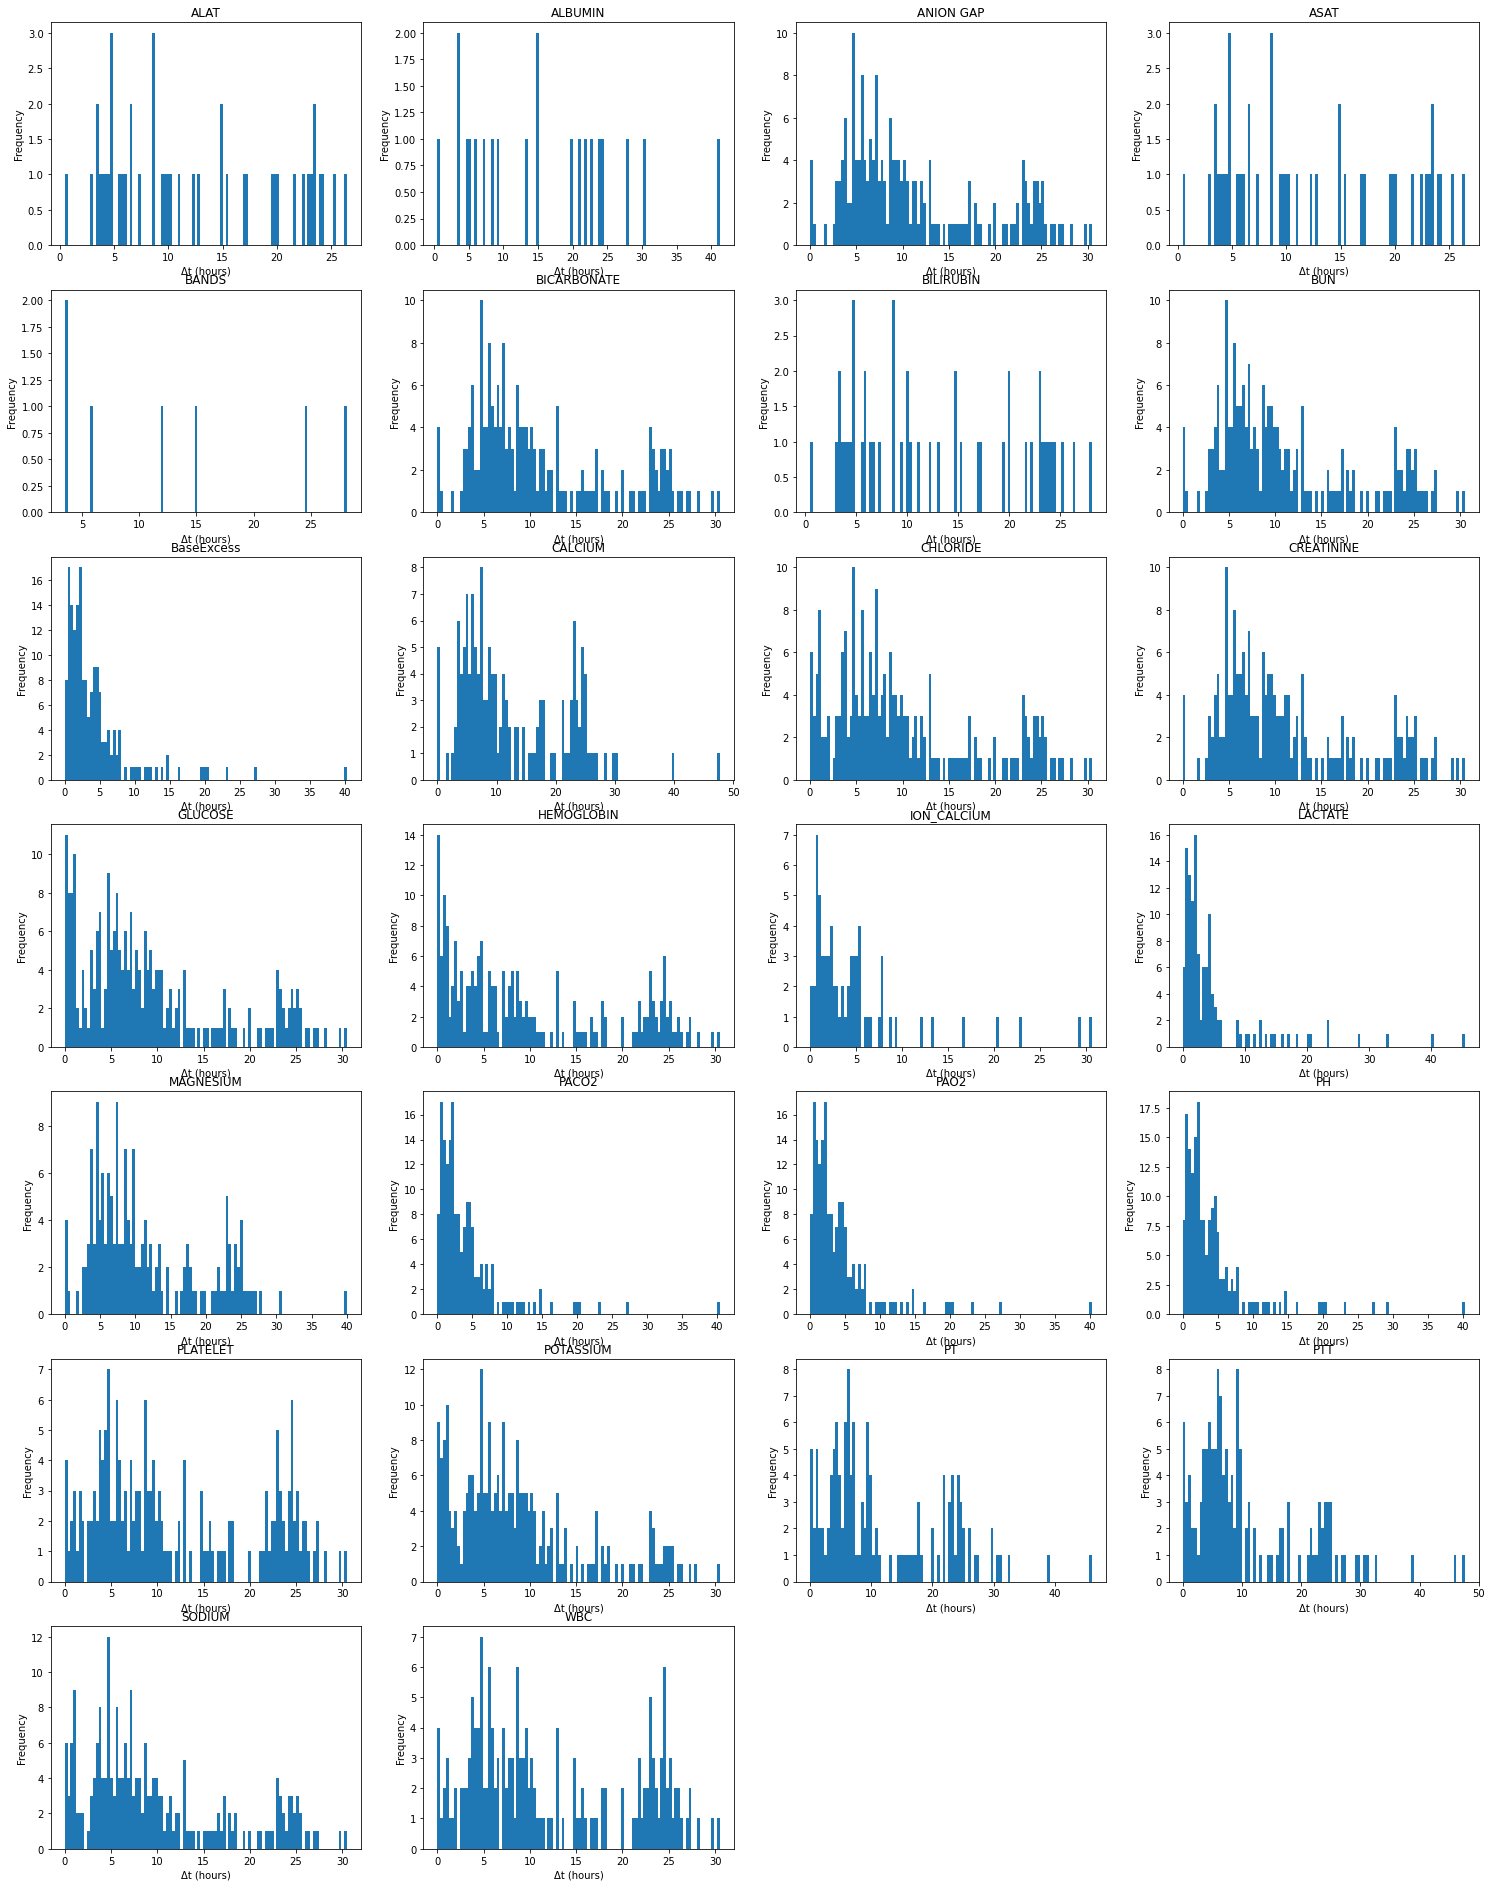

In [23]:
# Compute difference in measurement times for each lab result type in hours
lab_df = lab_df.sort_values(['icustay_id', 'charttime'])
lab_df['time_diff'] = lab_df.groupby(['icustay_id', 'lab_id'])['charttime'].diff().dt.total_seconds() / 3600

histogram_col_indexed(lab_df, value_col='time_diff', group_col='lab_id', xlabel='Δt (hours)', bins=100, num_cols=4)

*Remarks:*

1. Some lab values are more frequently measured (e.g. `Potassium`, `Sodium`, `Creatinine`) than others (`Albumin`, `ASAT`, `Bands`, `Bilirubin`)
1. Considerable spread in measurement values and measurement deltas ($\Delta t$); frequently beyond a day for some tests (e.g. thrombocytes/platelets).

---
## Vasopressor Administration (`vassopressors_cv/mv_cohort.csv`)

### 1. MetaVision Records

In [24]:
vaso_mv_df = read_csv(DATA_DIR + '/vassopressors_mv_cohort.csv')
vaso_mv_df.head()

,icustay_id,starttime,endtime,rate,rateuom,patientweight,vasoactive_drug,mcgkgmin,mcgmin
0,210989,2144-07-13 11:15:00,2144-07-13 11:30:00,8.013029,mcg/kg/min,81.7,dopamine,0.080130,6.546645
1,210989,2144-07-13 11:30:00,2144-07-13 11:50:00,0.502150,mcg/kg/min,81.7,norepinephrine,0.502150,41.025643
2,210989,2144-07-13 11:30:00,2144-07-13 11:50:00,10.012087,mcg/kg/min,81.7,dopamine,0.100121,8.179875
3,210989,2144-07-13 11:50:00,2144-07-13 11:55:00,0.251075,mcg/kg/min,81.7,norepinephrine,0.251075,20.512822
4,210989,2144-07-13 11:55:00,2144-07-13 19:06:00,0.200979,mcg/kg/min,81.7,norepinephrine,0.200979,16.419956


#### Frequency of vasoactive drug administered (norepinephrine-equiv.)

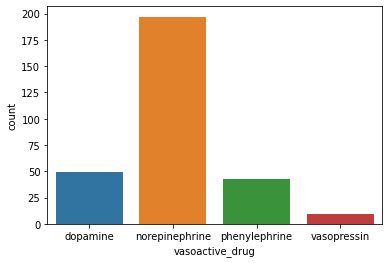

In [25]:
seaborn.countplot(x=vaso_mv_df["vasoactive_drug"]);

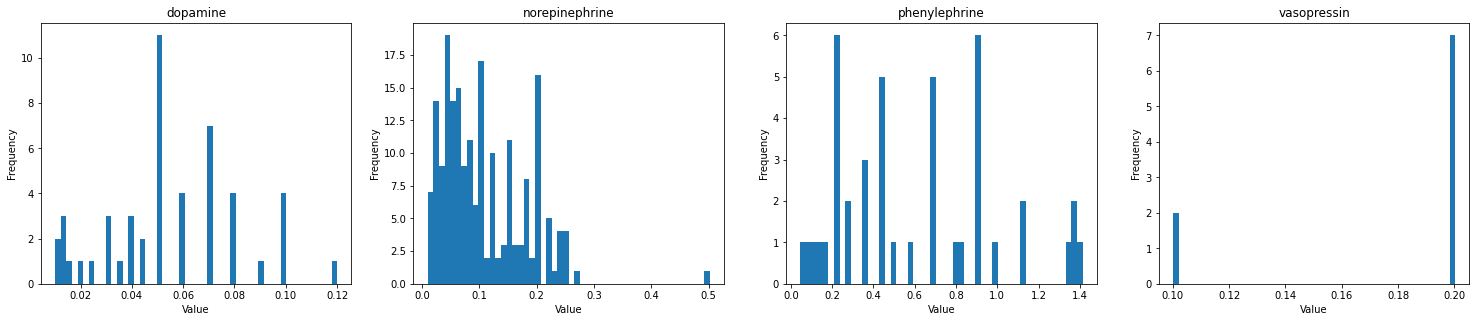

In [26]:
histogram_col_indexed(vaso_mv_df, value_col='mcgkgmin', group_col='vasoactive_drug', num_cols=4)

### 2. CareVue Records

In [27]:
vaso_cv_df = read_csv(DATA_DIR + '/vassopressors_cv_cohort.csv')
vaso_cv_df.head()

,icustay_id,charttime,rate,rateuom,vasoactive_drug,mcgkgmin
0,201006,2107-03-24 13:15:00,0.025000,mcgkgmin,norepinephrine,0.025000
1,201006,2107-03-24 13:30:00,0.045977,mcgkgmin,norepinephrine,0.045977
2,201006,2107-03-24 14:00:00,0.045977,mcgkgmin,norepinephrine,0.045977
3,201006,2107-03-24 15:00:00,0.068966,mcgkgmin,norepinephrine,0.068966
4,201006,2107-03-24 16:00:00,0.068966,mcgkgmin,norepinephrine,0.068966


#### Frequency of vasoactive drug administered (norepinephrine-equiv.)

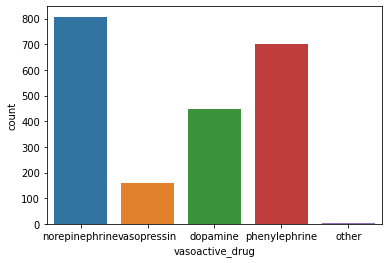

In [28]:
seaborn.countplot(x=vaso_cv_df["vasoactive_drug"]);

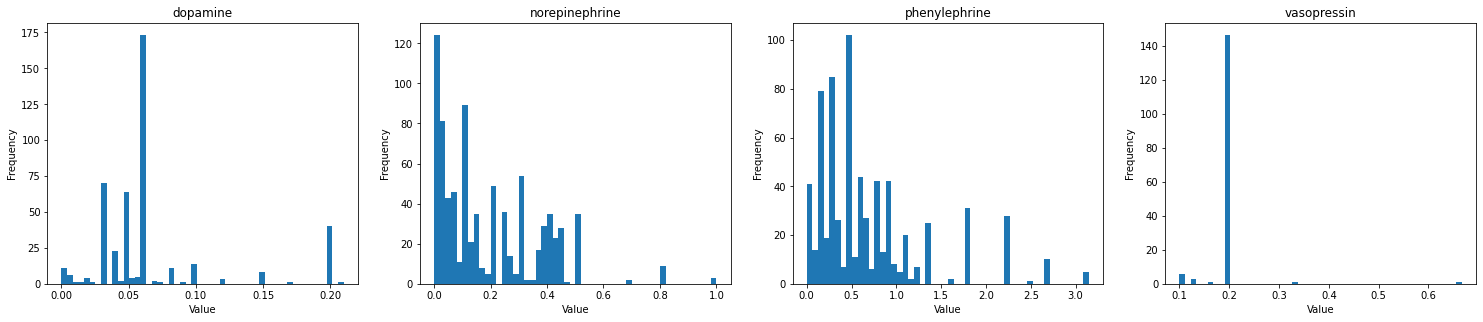

In [29]:
# Limit DataFrame to known vasoactive drugs
known_vaso_cv_df = vaso_cv_df[vaso_cv_df['vasoactive_drug'] != 'other']

histogram_col_indexed(known_vaso_cv_df, value_col='mcgkgmin', group_col='vasoactive_drug', num_cols=4)

*Remarks:*
1. Measurements are recorded by two systems: MetaVision and CareVue. MetaVision neatly records start/stop times for treatments; CareVue does not and only stores charttimes.
2. All measurements converted to `norepinephrine` equivalent doses.
3. Some vasopressors, such as `vasopressin`, are hardly ever administered; `norepinephrine` most often administered.

---
## IV Fluid Intake (`inputevents_cv/mv_cohort.csv`)

### 1. MetaVision Records

In [30]:
inputevents_mv_df = read_csv(DATA_DIR + '/inputevents_mv_cohort.csv')
inputevents_mv_df.head()

,subject_id,hadm_id,icustay_id,starttime,endtime,itemid,amount,amountuom,rate,rateuom,storetime,orderid,ordercategoryname,secondaryordercategoryname,ordercategorydescription,patientweight,totalamount,totalamountuom,statusdescription
0,40124,126179,279554,2130-02-04 16:11:00,2130-02-04 16:12:00,226452,120.000000,ml,NaN,NaN,2130-02-04 16:11:00,5833441,14-Oral/Gastric Intake,NaN,Bolus,41.5,120.0,ml,FinishedRunning
1,40124,126179,279554,2130-02-04 20:21:00,2130-02-05 04:07:00,225823,999.999978,ml,128.755362,mL/hour,2130-02-05 04:21:00,6416755,02-Fluids (Crystalloids),Additive (Crystalloid),Continuous IV,41.5,1000.0,ml,FinishedRunning
2,40124,126179,279554,2130-02-04 12:36:00,2130-02-04 18:39:00,225158,907.500000,ml,150.000000,mL/hour,2130-02-04 18:51:00,6795731,02-Fluids (Crystalloids),Additive (Crystalloid),Continuous IV,41.5,1000.0,ml,FinishedRunning
3,40124,126179,279554,2130-02-04 14:46:00,2130-02-05 09:01:00,225152,16429.999770,units,900.273960,units/hour,2130-02-05 09:14:00,7059405,01-Drips,02-Fluids (Crystalloids),Continuous Med,41.5,250.0,ml,FinishedRunning
4,40124,126179,279554,2130-02-04 14:46:00,2130-02-05 09:01:00,220949,164.299998,ml,9.002740,mL/hour,2130-02-05 09:14:00,7059405,01-Drips,02-Fluids (Crystalloids),Continuous Med,41.5,250.0,ml,FinishedRunning


#### Average volume of administration methods

In [31]:
total_iv_amount = inputevents_mv_df.groupby('ordercategoryname')['totalamount'].mean()
number_iv_type = inputevents_mv_df.groupby('ordercategoryname')['icustay_id'].count()
pd.DataFrame({'Avg. amount delivered': total_iv_amount, 'Frequency': number_iv_type})

,Avg. amount delivered,Frequency
ordercategoryname,,
01-Drips,178.203817,4558
02-Fluids (Crystalloids),546.229829,2045
03-IV Fluid Bolus,561.306533,201
04-Fluids (Colloids),116.935484,62
05-Med Bolus,NaN,546
06-Insulin (Non IV),NaN,354
07-Blood Products,314.851852,135
08-Antibiotics (IV),125.877193,1596
09-Antibiotics (Non IV),NaN,54


#### Distribution of IV fluids administered

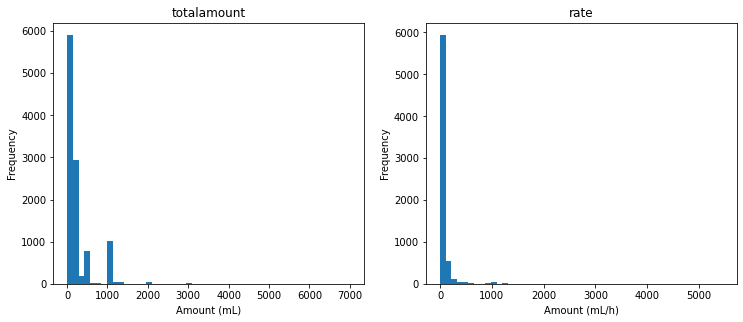

In [32]:
histogram_cols(inputevents_mv_df, col_names=['totalamount', 'rate'], xlabel=['Amount (mL)', 'Amount (mL/h)'], num_cols=4)

### 2. CareVue Records

In [33]:
inputevents_cv_df = read_csv(DATA_DIR + '/inputevents_cv_cohort.csv')

inputevents_cv_df.head()

,subject_id,hadm_id,icustay_id,charttime,itemid,amount,amountuom,rate,rateuom,storetime,orderid
0,10006,142345,206504,2164-10-24 06:00:00,30056,240.0,ml,NaN,NaN,2164-10-24 06:06:00,1968088
1,10006,142345,206504,2164-10-24 09:00:00,30056,250.0,ml,NaN,NaN,2164-10-24 10:36:00,3898092
2,10006,142345,206504,2164-10-24 18:00:00,30056,300.0,ml,NaN,NaN,2164-10-24 18:10:00,815226
3,10006,142345,206504,2164-10-24 09:00:00,30013,100.0,ml,NaN,NaN,2164-10-24 09:30:00,1850038
4,10006,142345,206504,2164-10-24 12:00:00,30013,0.0,ml,NaN,NaN,2164-10-24 12:08:00,8110354


#### Distribution of vasopressor administered (norepinephrine-equiv.)

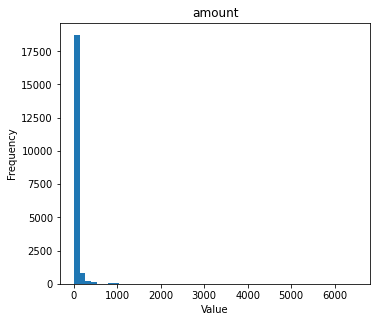

In [34]:
histogram_cols(inputevents_cv_df, col_names=['amount'], num_cols=4)

*Remarks:*
1. Most IV fluid intake was below 1 Liter in total.

--- 
## Urine Outputs (`urineoutput_cohort.csv`)

In [35]:
urineoutput_df = read_csv(DATA_DIR + '/urineoutput_cohort.csv')

urineoutput_df.head()

,subject_id,hadm_id,icustay_id,charttime,value
0,10045,126949,203766,2129-11-26 08:00:00,6
1,40310,186361,210989,2144-07-13 06:00:00,10
2,42075,151323,298685,2166-02-13 01:00:00,15
3,10032,140372,267090,2138-04-09 10:00:00,40
4,10044,124073,270154,2152-10-03 11:00:00,200


#### Distribution of values:

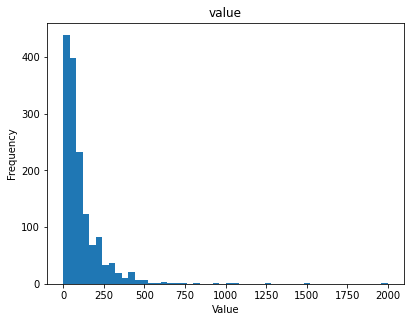

In [36]:
# Drop the one accidental negative urineoutput
urineoutput_df = urineoutput_df[urineoutput_df['value'] >= 0]

histogram_cols(urineoutput_df, col_names=['value'], num_cols=1)

#### Distribution of $\Delta t$:

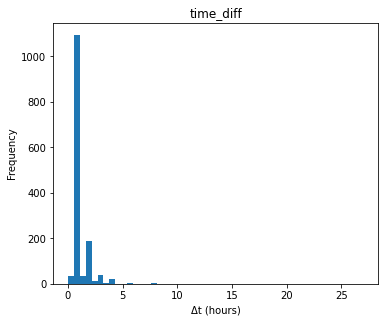

In [37]:
# Compute difference in measurement times for each measurement type in hours
urineoutput_df = urineoutput_df.sort_values(['icustay_id', 'charttime'])
urineoutput_df['time_diff'] = urineoutput_df.groupby(['icustay_id'])['charttime'].diff().dt.total_seconds() / 3600

histogram_cols(urineoutput_df, col_names=['time_diff'], xlabel='Δt (hours)', bins=50)

---
# Results & Implications

### TL;DR:

- Three main types of data in MIMIC-III:<br>
    1. *Static measurements*:
        - Quantities assumed to remain fixed throughout a stay (i.e. `demographics_cohort.csv`).
        - Examples: `age`, `weight`, `height`, `sofa` (on admission), `ethnicity`<br><br>
        
    2. *Timestamped point measurements*:
        - Measurements recorded at specific points in time.
        - **Irregular sampling**: changeable $\Delta t$ due to, e.g., variable scheduling of *lab tests*, *manually-performed measurements* or *missing data*.
        - **Asynchronous**: `HeartRate` and `UrineOutput` measurements are hardly ever registered at the same exact time as they are recorded by different devices resulting in `charttimes` being out of sync.
        - Examples: `HeartRate`, `TempC`, `RespRate`, `Mean/Sys/DiasBP`, `FiO2`, `Lactate/WBC/Bilirubin` levels, and so on.<br><br>
        
    3. *Interval-like data*:
        - Marking *start-* and *stop-times* of some treatment.
        - **Continuous**: Require sampling in order to 'live' in the same space as the point measurements.
        - Examples: `Continuous IV fluid`, `norepinephrine`, `dopamine` and `vasopressin`<br><br>
        
- Measurements are recorded by two systems: *MetaVision* and *CareVue*. MetaVision neatly records start/stop times for treatments; CareVue does not and only stores `charttimes`.<br><br>
        
- How to deal?:
    1. Static measurements, such as `age` and `weight`, can simply be concatenated to the final state representation (easy).<br><br>
    2. Irregular and asynchronous point measurements:
        - Option 1: **Average measurements** within predefined **$x$-hour bins** (e.g., smaller than *de facto standard* of 4 hours, e.g., 1 hour) and running a time-series model (e.g. a CKCNN) over the resulting, regular time series.
        - Option 2: **Resample** time-series at regular intervals $t$ using a **learned interpolation kernel** (e.g. using a modified* CKConv evaluated at, e.g., hourly steps)
        - Option 3: No further processing (i.e. timestamped measurements) and use a model capable of dealing with irregular data directly<br><br>
    3. Interval-like data requires **sampling** in order to be useful;
        - Sampling of intervals in which there are no treatments
        - Sampling intervals at average frequency of other measurements ($\approx$ 1 hour)?<br><br>
        
- Considerations for state encoding model:
    1. *Input data*:
         - Option 1: Average measurements within predefined $x$-hour bins (e.g. intervals of 1 hour) and apply standard CKCNN.
             - **Pros**: Simple (can largely reuse Roggeveen et al. preprocessing and [CKConv](https://github.com/dwromero/ckconv) repo without any major modifications)
             - **Cons**: (1) Loss of precision, (2) introduction of aliasing artifacts (e.g. on high-frequency signals such as `HeartRate`), and (3) how to interpolate sparse/missing measurements (i.e. missing `TempC` does not mean patient has a body temperature of 0°C)<br><br>
             
         - Option 2: Raw dataset as collection of irregularly-sampled time-series, $T=\langle(t_0^{k,p}, x_0^{k,p}), (t_1^{k,p}, x_1^{k,p}), ..., (t_N^{k,p}, x_N^{k,p})\rangle$ (for each feature $k$ and patient $p$). Resample series at regular points $t_j$ using a CKConv-based resampling kernel* and measurements $t_i$ to obtain a 'regularized' time-series; then apply standard CKCNN on the now regularly-sampled data.
             - **Pros**: (1) Simple to implement a modified* CKConv for resampling and (2) learned interpolation kernel resolves question how to interpolate each feature given missing data.
             - **Cons**: (1) loss of precision (though less so) and (2) aliasing artifacts.<br><br>
             
         - Option 3: Do not resample and simply use irregularly-sampled convolutions.
             - **Pros**: No loss of precision, nor aliasing artifacts.
             - **Cons**: (1) Asynchronously sampled time series hard to combine into unified, multi-feature CKCNN and (2) How to treat cases in which no treatment is administered? (i.e. no zero-treatment points unless explicitly created)<br><br>
         
    2. Convolutions over individual 1D time series (interpretable), or several features at once (less interpretable)?
    


\* In order to be able to use irregularly-sampled data with asynchronously recorded channels, the [CKConv](https://github.com/dwromero/ckconv) implementation must be modified to allow time-varying convolution kernels (which can be achieved by casting the convolution operation as a matrix-multiplication with a [Toeplitz matrix](https://www.gaussianwaves.com/2014/02/polynomials-convolution-and-toeplitz-matrices-connecting-the-dots/#:~:text=Toeplitz%20Matrix%20and%20Convolution%3A&text=Toeplitz%20matrix%20have%20constant%20entries,from%20the%20matrix%20structure%20itself.))